In [237]:
# importing necessary libraries:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings("ignore")

In [264]:
# Read all our data:
movie_gross_df = pd.read_csv(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\bom.movie_gross.csv.gz")
movie_info_df = pd.read_csv(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\rt.movie_info.tsv.gz", sep='\t')
movie_reviews_df = pd.read_csv(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\rt.reviews.tsv.gz", sep='\t', on_bad_lines='skip', encoding='latin1')
movies_df = pd.read_csv(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\tmdb.movies.csv.gz")
movie_budget_df = pd.read_csv(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\tn.movie_budgets.csv.gz")


# connecting to the database
conn = sqlite3.connect(r"C:\Users\USER\Desktop\project2\PHASE2_PROJECT-inferential-statistics-\data\im.db")
cursor = conn.cursor()
cursor.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
table_name = cursor.fetchall()
table_name

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [239]:
#movie_gross.head()

In [240]:
#movie_info.head()

In [241]:
#reviews.head()

In [266]:
movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [267]:
movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [268]:
movie_ratings = pd.read_sql("""SELECT * FROM movie_ratings""", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [271]:
movie_basics_df = pd.read_sql("""SELECT * FROM movie_basics""", conn)
movie_basics_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [270]:
#Create a function to clean up each dataset:
def clean(df):
    #to fill in null values for object types
    for col in df.select_dtypes(include='object').columns:
        df[col].fillna('unknown')
    #to fill in null values for numerical types
    mean_cols = ['popularity', 'vote_average']  # Columns where mean is more appropriate
    median_cols = ['production_budget', 'domestic_gross', 'foreign_gross', 
                   'worldwide_gross', 'vote_count'] #columns where median is more appropriate
    
    for col in mean_cols + median_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].replace(r'[^0-9\.]', '', regex=True), errors='coerce')

    for col in mean_cols:
        if col in df.columns:
            df[col].fillna(df[col].mean())
    for col in median_cols:
        if col in df.columns:
            df[col].fillna(df[col].median())
   
    #to fix inconsistent casing
    casing = df.select_dtypes(include = 'object').columns
    df[casing] = df[casing].apply(lambda x: x.str.lower())
   
    #remove whitespace
    df[casing] = df[casing].apply(lambda x: x.str.strip())
   
    #convert columns to numeric(get rid of commas, or currency signs)
    for col in df.columns:
        if 'gross' in col or 'budget' in col or 'revenue' in col:
            df[col] = pd.to_numeric(df[col].replace(r'[\$,]', '', regex=True), errors='coerce')
    
    #Return the clean Datasets
    return df


#apply cleaning to each dataset
movie_info_df = clean(movie_info_df)
movie_gross_df = clean(movie_gross_df)
movie_reviews_df = clean(movie_reviews_df)
movie_budgets_df = clean(movie_budget_df)
movies_df = clean(movies_df)



In [273]:
movie_basics_df1 = movie_basics_df.copy(deep = True)
# Lets split the genre column
movie_basics_df1['genre_split'] = movie_basics_df1['genres'].str.split(',').str[0]
movie_basics_df1.head(1)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,genre_split
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",Action


### Objective 5: Assess the impact of a film's popularity score and average rating on its overall performance.
Popularity and average rating are key indicators of a film's appeal and quality. By analyzing their impact, we can assess how they influence a film's financial success.

#### 5.1 Average Rating By Genre
This section compares the average ratings across different genres to assess which genres are rated highest

In [276]:
# we will merge movie_basics2, with movie_ratings using their common primary column:
ratings_basics = pd.merge(movie_basics_df1, movie_ratings, on='movie_id', how='inner')
ratings_basics = ratings_basics[['movie_id', 'primary_title', 'genre_split', 'averagerating', 'numvotes']]

ratings_basics.head()

,movie_id,primary_title,genre_split,averagerating,numvotes
0,tt0063540,Sunghursh,Action,7.0,77
1,tt0066787,One Day Before the Rainy Season,Biography,7.2,43
2,tt0069049,The Other Side of the Wind,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Comedy,6.1,13
4,tt0100275,The Wandering Soap Opera,Comedy,6.5,119


In [277]:
# Group by genre to calculate the mean rating and total number of votes
genre_analysis = ratings_basics.groupby('genre_split').agg({
    'averagerating': 'mean',
    'numvotes': 'sum'
}).reset_index()

# Sort by highest average rating and highest total votes
genre_analysis = genre_analysis.sort_values(by=['averagerating', 'numvotes'], ascending=[False, False])

# Display the top genres based on average rating
genre_analysis.head(10)

,genre_split,averagerating,numvotes
11,Game-Show,9.000000,7
14,Music,7.506771,42733
7,Documentary,7.316595,2974400
4,Biography,7.174512,17802454
21,Sport,6.944944,5262
15,Musical,6.637255,21663
12,History,6.413235,12851
2,Adventure,6.386710,27049347
8,Drama,6.370563,40837231
3,Animation,6.252391,1949018


In [278]:
# Group by genre to calculate the mean rating and total number of votes
genre_analysis = ratings_basics.groupby('genre_split').agg({
    'averagerating': 'mean',
    'numvotes': 'sum'
}).reset_index()

# Sort by highest total votes and then by highest average rating
genre_analysis = genre_analysis.sort_values(by=['numvotes', 'averagerating'], ascending=[False, False])

# Display the top genres with the highest number of votes
genre_analysis.head(10)

,genre_split,averagerating,numvotes
0,Action,5.810361,101161682
8,Drama,6.370563,40837231
5,Comedy,5.998505,40041881
2,Adventure,6.386710,27049347
4,Biography,7.174512,17802454
6,Crime,6.159102,13186709
13,Horror,4.856971,10635982
7,Documentary,7.316595,2974400
16,Mystery,6.091917,2379573
3,Animation,6.252391,1949018


#### 5.2 Popularity vs. Average Rating: Do High Ratings Indicate Popularity?

We examine the relationship between the number of votes (popularity) and average ratings to determine if high ratings truly reflect a genre's popularity.

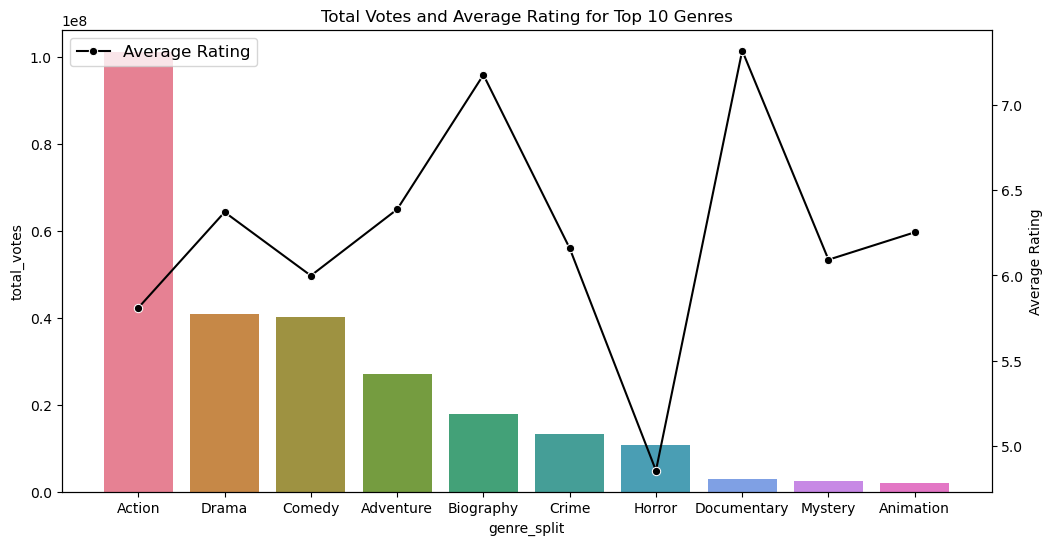

In [315]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by genre and calculate the total number of votes per genre
top_genre_summary = (ratings_basics.groupby('genre_split')
                     .agg(avg_rating=('averagerating', 'mean'),
                          total_votes=('numvotes', 'sum'))
                     .nlargest(10, 'total_votes')
                     .sort_values(by='total_votes', ascending=False))

# Set up the color palette for the genres
palette = sns.color_palette("husl", len(top_genre_summary))

# Create a figure and axes
plt.figure(figsize=(12, 6))

# Create a barplot for total votes
sns.barplot(x=top_genre_summary.index, y=top_genre_summary['total_votes'], palette=palette)

# Create a second y-axis for average rating with a lineplot
ax2 = plt.gca().twinx()
sns.lineplot(x=top_genre_summary.index, y=top_genre_summary['avg_rating'], color='black', marker='o', ax=ax2)

# Customize labels and title
plt.title('Total Votes and Average Rating for Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Total Votes (Popularity)')
ax2.set_ylabel('Average Rating')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add a legend to explain the line plot
ax2.legend(labels=['Average Rating'], loc='upper left', fontsize=12)

# Show plot
plt.show()


#### 5.3 Popularity Vs Gross Profit
We need to examine if higher popularity leads to greater financial success

In [296]:
# Convert columns to numeric
movie_budgets_df[['worldwide_gross', 'domestic_gross', 'production_budget']] = movie_budgets_df[['worldwide_gross', 'domestic_gross', 'production_budget']].apply(pd.to_numeric, errors='coerce')

# Create the 'Gross_profit' column
movie_budgets_df['Gross_profit'] = (movie_budgets_df['worldwide_gross'] + movie_budgets_df['domestic_gross']) - movie_budgets_df['production_budget']


In [ ]:
# 2. Merge movie_budgets with movies_merged on 'movie' and 'original_title'
movies_merged = pd.merge(movies_df, movie_budgets_df, left_on='original_title', right_on='movie', how='inner')

movies_analysis = movies_merged[['original_title', 'popularity', 'vote_average', 'vote_count', 'domestic_gross', 'worldwide_gross', 'Gross_profit']]
# Convert columns to numeric, forcing errors to NaN for non-numeric entries
movies_analysis['Gross_profit'] = pd.to_numeric(movies_analysis['Gross_profit'], errors='coerce')
movies_analysis['popularity'] = pd.to_numeric(movies_analysis['popularity'], errors='coerce')
movies_analysis['production_budget'] = pd.to_numeric(movies_analysis['production_budget'], errors='coerce')

movies_analysis.head()

,original_title,popularity,vote_average,vote_count,domestic_gross,worldwide_gross,Gross_profit
0,how to train your dragon,28.734,7.7,7610,217581232,494870992,547452224
1,iron man 2,28.515,6.8,12368,312433331,621156389,763589720
2,toy story,28.005,7.9,10174,191796233,364545516,526341749
3,inception,27.920,8.3,22186,292576195,835524642,968100837
4,percy jackson & the olympians: the lightning t...,26.691,6.1,4229,88768303,223050874,216819177


In [283]:
# 4. Analyze correlation to see the relationship between each column
correlations = movies_analysis[['popularity', 'vote_average', 'worldwide_gross', 'Gross_profit']].corr()
print("Correlation matrix:\n", correlations)

Correlation matrix:
                  popularity  vote_average  worldwide_gross  Gross_profit
popularity         1.000000      0.304523         0.574615      0.547444
vote_average       0.304523      1.000000         0.195774      0.205487
worldwide_gross    0.574615      0.195774         1.000000      0.985592
Gross_profit       0.547444      0.205487         0.985592      1.000000


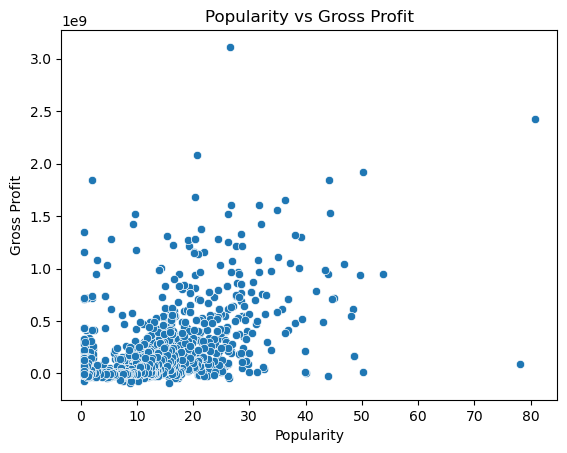

In [284]:
#Popularity vs gross profit:
sns.scatterplot(x='popularity', y='Gross_profit', data=movies_analysis)
plt.title('Popularity vs Gross Profit')
plt.xlabel('Popularity')
plt.ylabel('Gross Profit')
plt.show()

#### 5.4 Vote Average vs. Gross Profit
Explore is higher ratings correlate with better box office performance

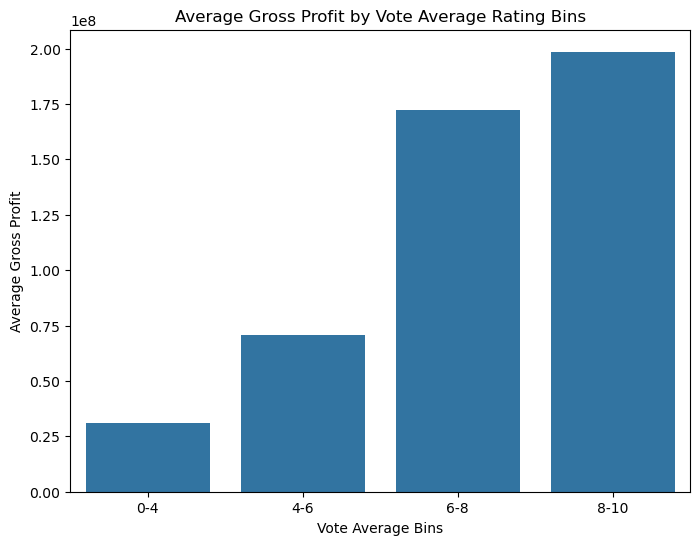

In [285]:
# Create bins for vote_average
bins = [0, 4, 6, 8, 10]
labels = ['0-4', '4-6', '6-8', '8-10']
movies_analysis['rating_bins'] = pd.cut(movies_analysis['vote_average'], bins=bins, labels=labels)

# Calculate the mean Gross Profit for each rating bin
mean_profit_by_rating = movies_analysis.groupby('rating_bins')['Gross_profit'].mean().reset_index()

# Bar plot for Vote Average Bins vs Gross Profit
plt.figure(figsize=(8,6))
sns.barplot(x='rating_bins', y='Gross_profit', data=mean_profit_by_rating)
plt.title('Average Gross Profit by Vote Average Rating Bins')
plt.xlabel('Vote Average Bins')
plt.ylabel('Average Gross Profit')
plt.show()

#### 5.5 Vote Count vs. Gross Profit
Explore if higher ratings correlate with better box office performance

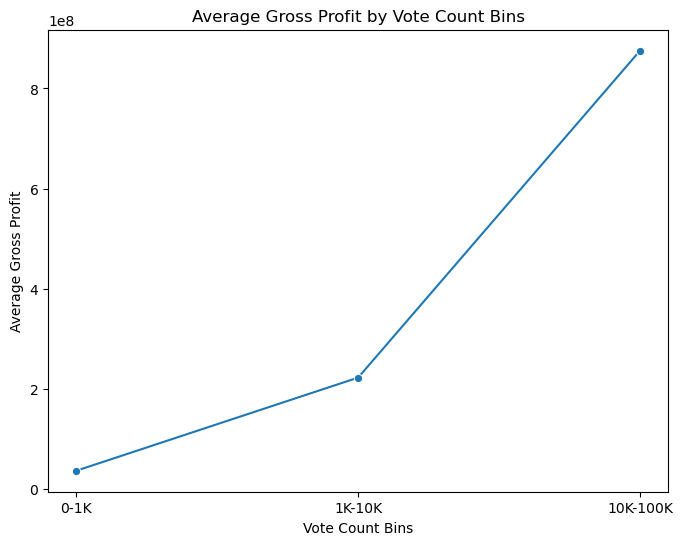

In [286]:
# Create bins for vote_count
bins = [0, 1000, 10000, 100000, 1000000]
labels = ['0-1K', '1K-10K', '10K-100K', '100K-1M']
movies_analysis['vote_count_bins'] = pd.cut(movies_analysis['vote_count'], bins=bins, labels=labels)

# Calculate the mean Gross Profit for each vote count bin
mean_profit_by_vote_count = movies_analysis.groupby('vote_count_bins')['Gross_profit'].mean().reset_index()

# Line plot for Vote Count Bins vs Gross Profit
plt.figure(figsize=(8,6))
sns.lineplot(x='vote_count_bins', y='Gross_profit', data=mean_profit_by_vote_count, marker='o')
plt.title('Average Gross Profit by Vote Count Bins')
plt.xlabel('Vote Count Bins')
plt.ylabel('Average Gross Profit')
plt.show()

#### 5.6 Vote Average vs. Vote Count
Analyze if higher ratings attract more votes and reflect popularity

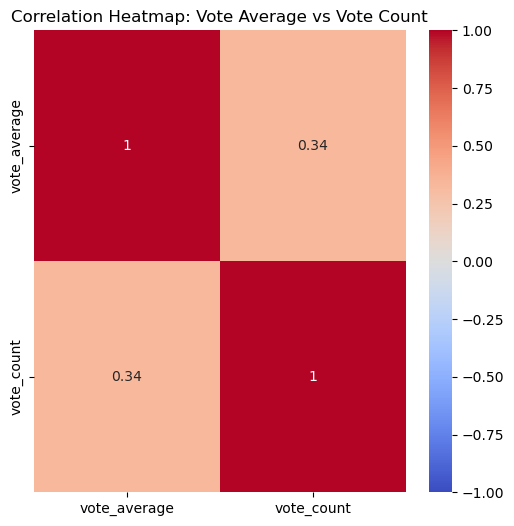

In [287]:
# Correlation heatmap for Vote Average vs Vote Count
corr_matrix = movies_analysis[['vote_average', 'vote_count']].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Vote Average vs Vote Count')
plt.show()

#### 5.6 Top 10 Movies by Popularity with Gross Profit
Explore the relationship between a movie's popularity with it's financial success. In the end, we will be able to see the films with the highest popularity score and compare their gross profit

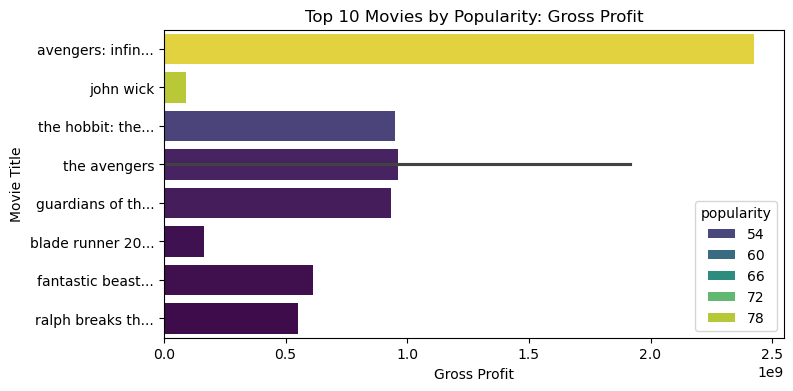

In [ ]:

# Sort movies by popularity and select top 10
top_movies = movies_analysis.sort_values(by='popularity', ascending=False).head(10).copy()

# Abbreviate long titles
top_movies['short_title'] = top_movies['original_title'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)

# Create a figure and axes
plt.figure(figsize=(8, 4))

# Create a barplot using seaborn
sns.barplot(data=top_movies, y='short_title', x='Gross_profit', hue='popularity', palette='viridis', dodge=False)

# Add titles and labels
plt.title('Top 10 Movies by Popularity: Gross Profit')
plt.xlabel('Gross Profit')
plt.ylabel('Movie Title')

# Show plot
plt.show()


In [289]:
# Sort the movies by popularity in descending order and display the top 10 films
top_popular_movies = movies_analysis.sort_values(by='popularity', ascending=False).head(10)

# Display the top 10 most popular films
top_popular_movies[['original_title', 'popularity']]


,original_title,popularity
2179,avengers: infinity war,80.773
1080,john wick,78.123
1081,the hobbit: the battle of the five armies,53.783
570,the avengers,50.289
571,the avengers,50.289
1082,guardians of the galaxy,49.606
2180,blade runner 2049,48.571
1946,blade runner 2049,48.571
2181,fantastic beasts: the crimes of grindelwald,48.508
2182,ralph breaks the internet,48.057


### Hypothesis Testing

1. Null Hypothesis (H0): There is no significant difference in the average box office revenue between popular and less popular movies.
2. Alternative Hypothesis (H1): Popular movies have a higher average box office revenue compared to less popular movies

In [299]:
# Display basic statistics:
movies_analysis.describe()

,popularity,vote_average,vote_count,domestic_gross,worldwide_gross,Gross_profit
count,2379.000000,2379.000000,2379.000000,2.379000e+03,2.379000e+03,2.379000e+03
mean,10.658189,6.211475,1692.971837,4.915213e+07,1.188769e+08,1.303450e+08
std,8.242882,1.181166,2680.617514,8.200950e+07,2.198732e+08,2.602599e+08
min,0.600000,0.000000,1.000000,0.000000e+00,0.000000e+00,-9.000000e+07
25%,5.459000,5.600000,63.000000,7.141095e+05,3.186510e+06,-5.000000e+05
50%,9.486000,6.300000,605.000000,1.970116e+07,3.658851e+07,3.434830e+07
75%,14.380000,6.900000,2091.500000,5.802082e+07,1.233483e+08,1.390011e+08
max,80.773000,10.000000,22186.000000,7.605076e+08,2.776345e+09,3.111853e+09


In [ ]:
# Calculate the population mean and standard deviation
mean_all = movies_analysis['Gross_profit'].mean()
std_all = movies_analysis['Gross_profit'].std()

# Create a sample to work with:
np.random.seed(42)
sample_size = 500
analysis_sample = movies_analysis['Gross_profit'].sample(n=sample_size, random_state=42)
#create the mean of our sample:
mean_sample = analysis_sample.mean()


# Display calculated statistics
print("Population Mean (All Movies):", mean_all)
print("Population Standard Deviation (All Movies):", std_all)
print("Sample Mean (Popular Movies):", mean_sample)
print("Sample Size (Popular Movies):", sample_size)

Population Mean (All Movies): 130344990.05968894
Population Standard Deviation (All Movies): 260259879.57320037
Sample Mean (Popular Movies): 122061345.662
Sample Size (Popular Movies): 500


In [293]:
# Perform the Z-test
z_score = (mean_sample - mean_all) / (std_all / np.sqrt(sample_size))
p_value = 1 - stats.norm.cdf(z_score)  # One-tailed test if testing for higher average profit

# Display results
print("Population Mean Gross Profit:", mean_all)
print("Sample Mean Gross Profit:", mean_sample)
print("Z-score:", z_score)
print("P-value:", p_value)

# Step 5: Conclusion based on significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The sample of movies has a significantly higher average gross profit.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average gross profit for the sample.")

Population Mean Gross Profit: 130344990.05968894
Sample Mean Gross Profit: 122061345.662
Z-score: -0.7117037018937863
P-value: 0.7616758625846729
Fail to reject the null hypothesis: No significant difference in average gross profit for the sample.


### Conclusion

In conclusion, this analysis shows that high popularity scores are a strong predictor of box office success, while high ratings do not always mean higher profits. Popularity—likely due to strong marketing and franchise appeal—has the greatest effect on profit. Additionally, genre trends affect both ratings and profit, reflecting audience preferences. These findings suggest that focusing on popularity and genre trends can help studios increase their box office returns.